In [1]:
from pathlib import Path

In [2]:
from train_eval import *

In [3]:
import cli

In [13]:
opts = cli.RunOptions()
opts.dataset_malignant_256=Path("/home/a.khamutov/kaggle-datasource/jpeg-melanoma-256x256")
opts.dataset_official=Path("/home/a.khamutov/kaggle")
opts.num_workers=0
opts.device="cuda:1"

config = opts
torch.cuda.set_device(config.device)

In [14]:
train_df, test_df, meta_features = load_dataset(opts)

In [15]:
train_transform = transforms.Compose([
    #     HairGrowth(hairs = 5,hairs_folder='/kaggle/input/melanoma-hairs/'),
    transforms.RandomResizedCrop(size=256, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=32. / 255., saturation=0.5, hue=0.01),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [16]:
def get_train_val_split(df):
    #Remove Duplicates
    df = df[df.tfrecord != -1].reset_index(drop=True)
    #We are splitting data based on triple stratified kernel provided here https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/165526
    train_tf_records = list(range(len(df.tfrecord.unique())))[:12]
    split_cond = df.tfrecord.apply(lambda x: x in train_tf_records)
    train_df = df[split_cond].reset_index()
    valid_df = df[~split_cond].reset_index()
    return train_df,valid_df

In [17]:
df_trn, df_vld = get_train_val_split(train_df)

In [18]:
class MelanomaDataset(Dataset):
    def __init__(self, df: pd.DataFrame, imfolder: str, is_train: bool = True, transforms=None, meta_features=None):

        self.df = df
        self.imfolder = imfolder
        self.transforms = transforms
        self.is_train = is_train
        self.meta_features = meta_features

    def __getitem__(self, index):
        im_path = os.path.join(self.imfolder, self.df.iloc[index]['image_name'] + '.jpg')
        image = cv2.imread(im_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        metadata = np.array(self.df.iloc[index][self.meta_features].values, dtype=np.float32)

        if self.transforms:
            image = self.transforms(image)

        if self.is_train:
            y = self.df.iloc[index]['target']
            #             image = image.cuda()
            return (image, metadata), float(y)
        else:
            return (image, metadata)

    def __len__(self):
        return len(self.df)

In [19]:
class EfficientNetwork(nn.Module):
    def __init__(self, output_size, no_columns, model_name='efficientnet-b0'):
        super().__init__()
        self.no_columns = no_columns

        self.features = EfficientNet.from_pretrained(model_name)

        # (CSV) or Meta Features
        meta_features_out = 250
        self.csv = nn.Sequential(nn.Linear(self.no_columns, 250),
                                 nn.BatchNorm1d(250),
                                 nn.ReLU(),
                                 nn.Dropout(p=0.3),

                                 nn.Linear(250, 250),
                                 nn.BatchNorm1d(250),
                                 nn.ReLU(),
                                 nn.Dropout(p=0.3),

                                 nn.Linear(250, meta_features_out),
                                 nn.BatchNorm1d(meta_features_out),
                                 nn.ReLU(),
                                 nn.Dropout(p=0.3))

        self.eff_net_out_features = getattr(self.features, '_fc').in_features

        fc_hidden_size = 250
        self.classification = nn.Sequential(nn.Linear(self.eff_net_out_features + meta_features_out, fc_hidden_size),
                                            nn.Linear(fc_hidden_size, output_size))

    def forward(self, data, prints=False):
        
        image, csv_data = data[0], data[1]

        if prints:
            print('Input Image shape:', image.shape, '\n' +
                  'Input csv_data shape:', csv_data.shape)

        # IMAGE CNN
        image = self.features.extract_features(image)

        if prints:
            print('Features Image shape:', image.shape)

        # image = F.avg_pool2d(image, image.size()[2:]).reshape(-1, self.eff_net_out_features)
        features = F.adaptive_avg_pool2d(image, 1)
        image = features.view(features.size(0), -1)
        if prints:
            print('Image Reshaped shape:', image.shape)

        # CSV FNN
        csv_data = self.csv(csv_data)
        if prints:
            print('CSV Data:', csv_data.shape)

        # Concatenate
        image_csv_data = torch.cat((image, csv_data), dim=1)

        # CLASSIF
        out = self.classification(image_csv_data)
        if prints:
            print('Out shape:', out.shape)

        return out.squeeze()

In [23]:
output_size = 1
train_dataset = MelanomaDataset(df=df_trn,
                                imfolder=config.dataset_malignant_256 / 'train',
                                is_train=True,
                                transforms=train_transform,
                                meta_features=meta_features)
# val = MelanomaDataset(df=df_vld,
#                       imfolder=config.dataset_malignant_256 / 'train',
#                       is_train=True,
#                       transforms=test_transform,
#                       meta_features=meta_features)
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=config.batch_size,
                          shuffle=True,
                          num_workers=config.num_workers,
                          pin_memory=True,
                          drop_last=True)
# val_loader = DataLoader(dataset=val,
#                         batch_size=config.batch_size,
#                         shuffle=False,
#                         num_workers=config.num_workers,
#                         pin_memory=True)

model = EfficientNetwork(output_size=output_size, no_columns=len(meta_features), model_name='efficientnet-b0')
model = model.to(config.device)

criterion = nn.BCEWithLogitsLoss()

config.learning_rate = 1e-8
config.weight_decay = 1e-4
optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)



Loaded pretrained weights for efficientnet-b0


Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()


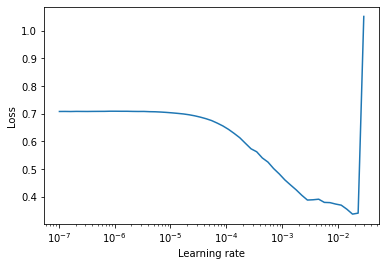

In [24]:
from torch_lr_finder import LRFinder

lr_finder = LRFinder(model, optimizer, criterion, config.device)
lr_finder.range_test(train_loader, end_lr=100, num_iter=100, start_lr=1e-8)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state